In [1]:
from ctapipe.io import EventSource, SimTelEventSource
from ctapipe import utils
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.containers import FlatFieldContainer
from ctapipe.calib.camera.flatfield import FlasherFlatFieldCalculator
from ctapipe.calib.camera.flatfield import FlatFieldCalculator
from matplotlib import pyplot as plt
import numpy as np
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization  import CameraDisplay
from traitlets.config.loader import Config
from ctapipe.core import traits
from ctapipe.calib import CameraCalibrator
from copy import deepcopy, copy
from ctapipe.io import TableLoader
import astropy.units as u
%matplotlib notebook

In [5]:
input_url = "gamma_20deg_0deg_run1555___cta-prod6-paranal-2147m-Paranal-dark-bs5.0-10k-lfa64.simtel.zst"
print(input_url)
source = EventSource(input_url)
subarray = source.subarray

calibrator = CameraCalibrator(subarray=source.subarray, image_extractor_type = 'FlashCamExtractor')

#Initiliaze arrays
mean_times = np.array([])
event_ids = np.array([])
tel_ids = np.array([])


for event in source:
    
    calibrator(event)
    
    for tel_id in (event.r0.tel.keys()):
        if tel_id in np.unique(events["MST_MST_FlashCam"]["tel_id"]):
            t = source.file_.current_photoelectrons[tel_id-1]['time']

            mean_time = np.array([])
            for pix_id in np.unique(source.file_.current_photoelectrons[tel_id-1]['pixel_id']):
                mean_time = np.append(mean_time, np.mean(t[source.file_.current_photoelectrons[tel_id-1]['pixel_id'] == pix_id]))
                tel_ids = np.append(tel_ids, tel_id)
                event_ids = np.append(event_ids, event.count)

            mean_time = mean_time - np.mean(mean_time)
            mean_times = np.append(mean_times, mean_time)

gamma_20deg_0deg_run1555___cta-prod6-paranal-2147m-Paranal-dark-bs5.0-10k-lfa64.simtel.zst


In [3]:
# FlashCam extractor.
loader = TableLoader("gamma_prod6_1k.dl1.h5", 
                     load_true_images = True, 
                     load_dl1_images = True,
                     load_dl1_parameters=False,
                    )     
events = loader.read_telescope_events_by_type()

In [4]:
events['MST_MST_FlashCam'][:10]

obs_id,event_id,tel_id,image,peak_time,image_mask,is_valid,true_image_sum,true_image,time,tels_with_trigger,event_type
int32,int64,int16,float32[1764],float32[1764],bool[1764],bool,int32,int32[1764],Time,bool[87],int64
1555,1901,10,0.24893296 .. 4.171102,13.430633 .. 29.88083,False .. False,True,77,0 .. 0,59809.91045552352,False .. False,32
1555,1901,24,-3.747272 .. -3.7227454,63.396786 .. 67.77457,False .. False,True,67,0 .. 0,59809.91045552352,False .. False,32
1555,1901,30,2.996516 .. 2.0777884,9.455813 .. 86.80229,False .. False,True,90,0 .. 0,59809.91045552352,False .. False,32
1555,5503,23,-1.3514255 .. -3.8010073,55.825504 .. 88.125015,False .. False,True,739,0 .. 0,59809.9115809982,False .. False,32
1555,5503,31,0.025709258 .. -1.6471455,64.6115 .. -0.21908846,False .. False,True,1171,0 .. 0,59809.9115809982,False .. False,32
1555,5506,26,-0.6796841 .. 8.6066,39.279453 .. 42.361904,False .. True,True,3226,0 .. 9,59809.91160117771,False .. False,32
1555,5506,32,-2.6119993 .. 4.990502,47.75975 .. 21.221918,False .. False,True,834,0 .. 1,59809.91160117771,False .. False,32
1555,5506,37,-1.3181036 .. -3.8591938,84.28829 .. 68.06993,False .. False,True,398,0 .. 0,59809.91160117771,False .. False,32
1555,5508,28,1.3108866 .. 3.2282584,20.395365 .. 49.384323,False .. False,True,160,0 .. 0,59809.911612453194,False .. True,32


In [6]:
#Disabled pixels

tel_id = next(iter(event.dl1.tel.keys()))
print(tel_id)
flashcam_disabled_pixels = event.mon.tel[tel_id].pixel_status.hardware_failing_pixels[0]
good_pixels = ~flashcam_disabled_pixels
print(flashcam_disabled_pixels)

22
[False False False ... False False False]


<IPython.core.display.Javascript object>


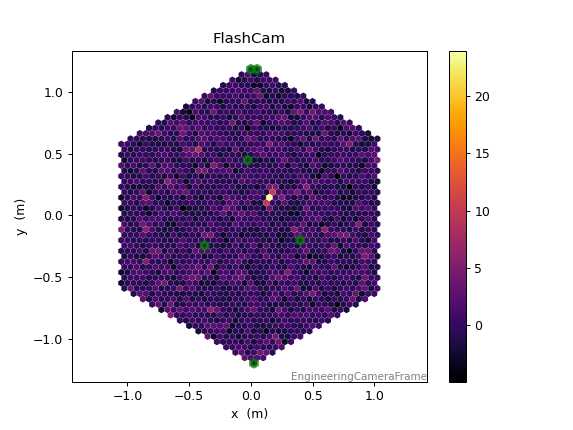

In [7]:
# PLot one flatfield event

camera_geometry = source.subarray.tel[tel_id].camera.geometry

# the default coordinate system is `CameraFrame`, which is used in the simulation
# this frame is unusual for people working with the camera hardware, we can transform
# to `EngineeringCameraFrame` for a more common orientation:
from ctapipe.coordinates import EngineeringCameraFrame

camera_geometry = camera_geometry.transform_to(EngineeringCameraFrame())

image = event.dl1.tel[tel_id].image
image[flashcam_disabled_pixels] = 0

fig = plt.figure()
disp = CameraDisplay(
    camera_geometry,
    image=image,
)
disp.add_colorbar()
disp.highlight_pixels(flashcam_disabled_pixels, linewidth=3)

<IPython.core.display.Javascript object>


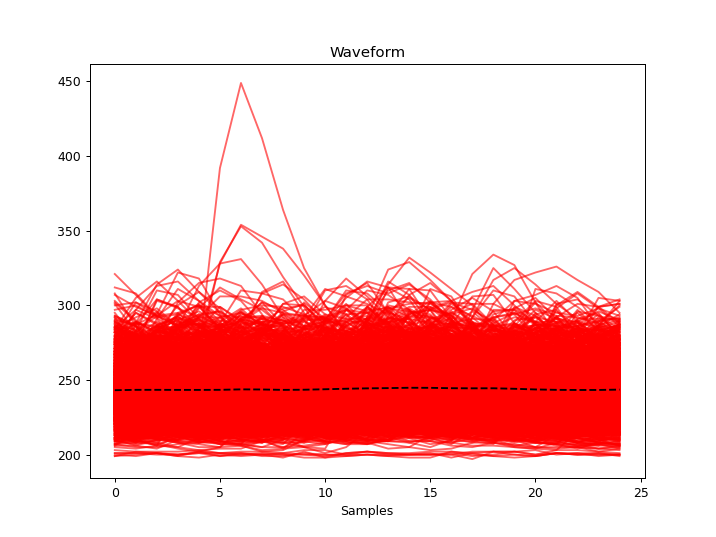

Text(0, 0.5, '')

In [12]:
# Plotting the waveforms. They should look very similar.

fig,ax = plt.subplots(1,1, figsize = (8, 6))

wv = event.r0.tel[tel_id].waveform[0]

for pix, pix_wave in enumerate(wv):
    ax.plot(pix_wave, color = "red", alpha = 0.6)

plt.plot(wv.mean(axis=0), color='black', linestyle='--')
plt.title("Waveform")
plt.xlabel("Samples")
plt.ylabel("")

In [13]:
# Good pixels

true_pe = np.array([])
recon_pe = np.array([])
recon_mean = np.array([])

for tel_type, table in events.items():
    if tel_type == 'MST_MST_FlashCam':
            good_pixels = ~flashcam_disabled_pixels
    else:
        good_pixels = slice(None)
        
    images = table["image"]
    true_images = table["true_image"]
    
    pixel_values = images[:, good_pixels]
    true_pixel_values = true_images[:, good_pixels]
    good_times = table["peak_time"][:, good_pixels]
    
    noise = pixel_values[true_pixel_values == 0]
    
    if tel_type == 'MST_MST_FlashCam':
        true_pe = np.append(true_pe, true_pixel_values[true_pixel_values > 0])
        recon_pe = np.append(recon_pe, pixel_values[true_pixel_values > 0])
        recon_mean = np.append(recon_mean, good_times[true_pixel_values > 0])

In [14]:
def compute_profile(x, y, nbin=(100,100)):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

<IPython.core.display.Javascript object>


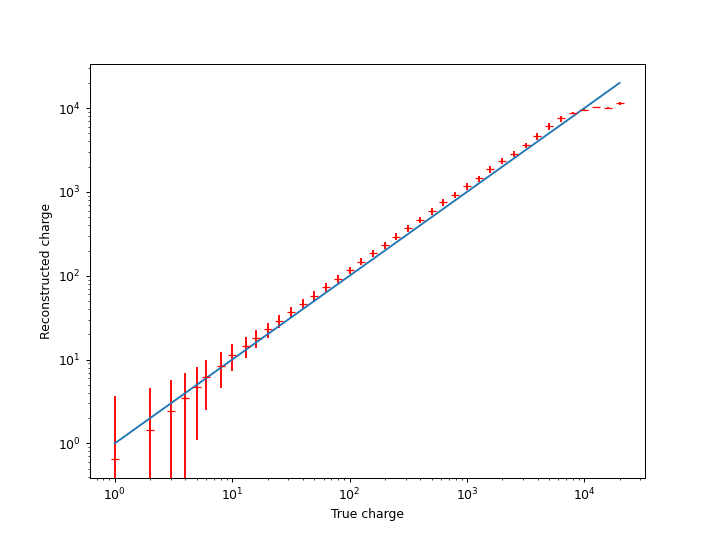

In [15]:
bins=np.unique(np.round(np.logspace(0, 5, 51))) - 0.5   #Logarithmic binning

p_x, p_mean, p_rms = compute_profile(true_pe, recon_pe, (bins,bins))

fig = plt.figure(figsize=(8,6))

plt.xscale('log')
plt.yscale('log')
plt.xlabel("True charge")
plt.ylabel("Reconstructed charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.plot(p_x, p_x)
plt.show()

<IPython.core.display.Javascript object>


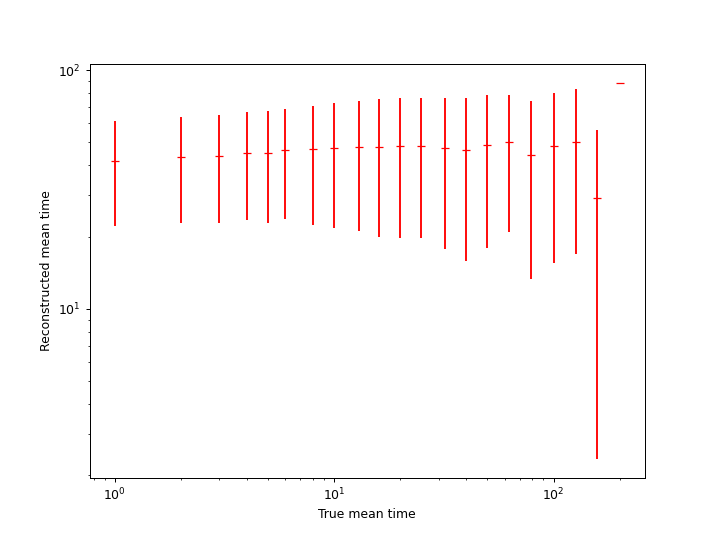

In [17]:
p_x, p_mean, p_rms = compute_profile(mean_times, recon_mean, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True mean time")
plt.ylabel("Reconstructed mean time")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.show()

<IPython.core.display.Javascript object>


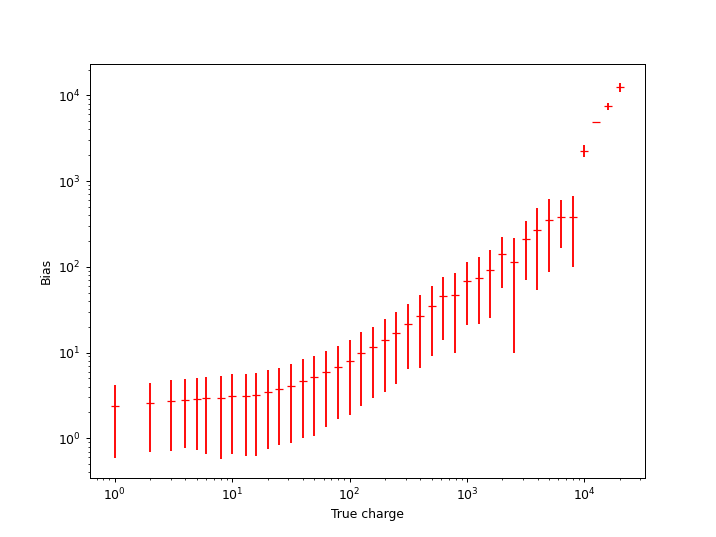

In [18]:
p_x, p_mean, p_rms = compute_profile(true_pe, np.abs(recon_pe-true_pe), (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True charge")
plt.ylabel("Bias")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.show()

<IPython.core.display.Javascript object>


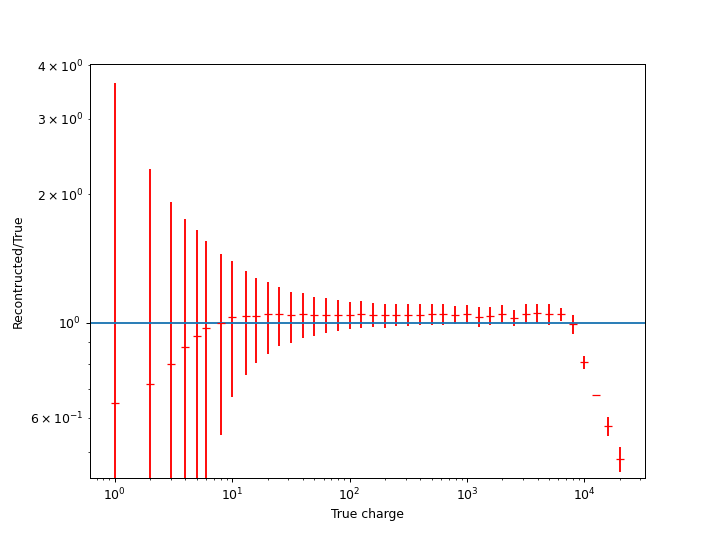

In [19]:
p_x, p_mean, p_rms = compute_profile(true_pe, recon_pe/true_pe, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Recontructed/True")
plt.xlabel("True charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.axhline(y=1)
plt.show()

<IPython.core.display.Javascript object>


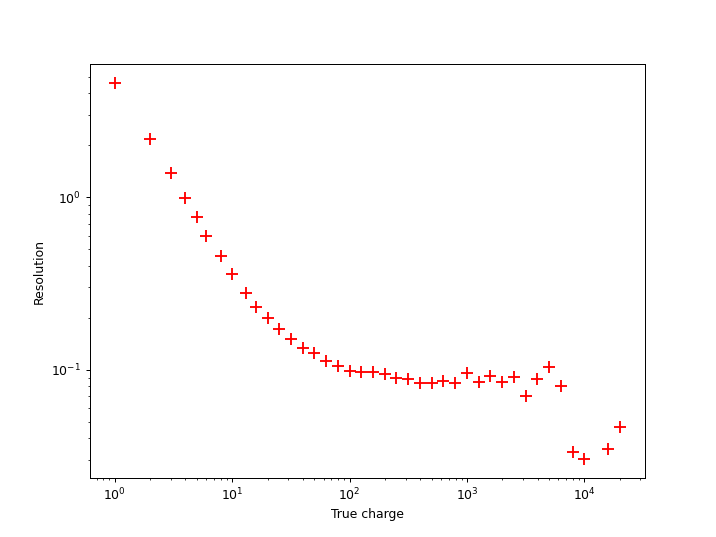

In [20]:
p_x, p_mean, p_rms = compute_profile(true_pe, recon_pe, (bins,bins))

plt.figure(figsize=(8, 6))

plt.scatter(p_x, p_rms/p_mean, color='red', marker='+', s=80)

plt.xscale('log')
plt.yscale('log')
plt.ylabel("Resolution")
plt.xlabel("True charge")
plt.show()

<IPython.core.display.Javascript object>


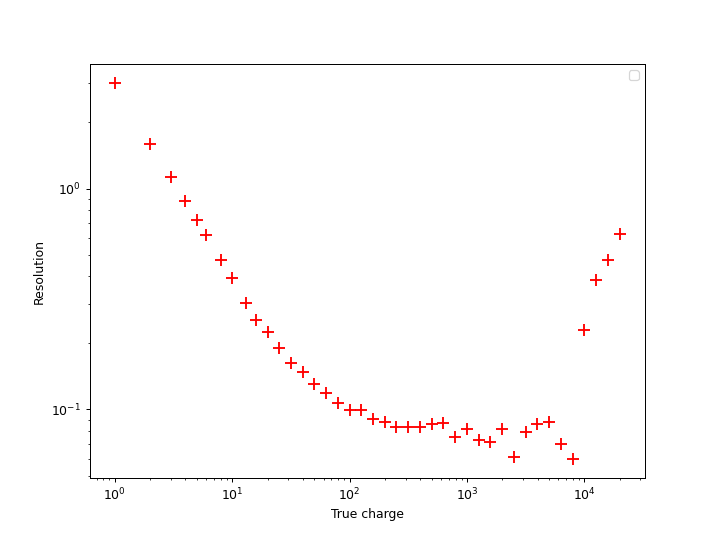

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [22]:
# Resolution with RMS

p_x, p_mean, p_rms = compute_profile(true_pe, (recon_pe-true_pe)**2, (bins,bins))

plt.figure(figsize=(8, 6))

plt.scatter(p_x, np.sqrt(p_mean)/p_x, color='red', marker='+', s=80)

plt.xscale('log')
plt.yscale('log')
plt.ylabel("Resolution")
plt.xlabel("True charge")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


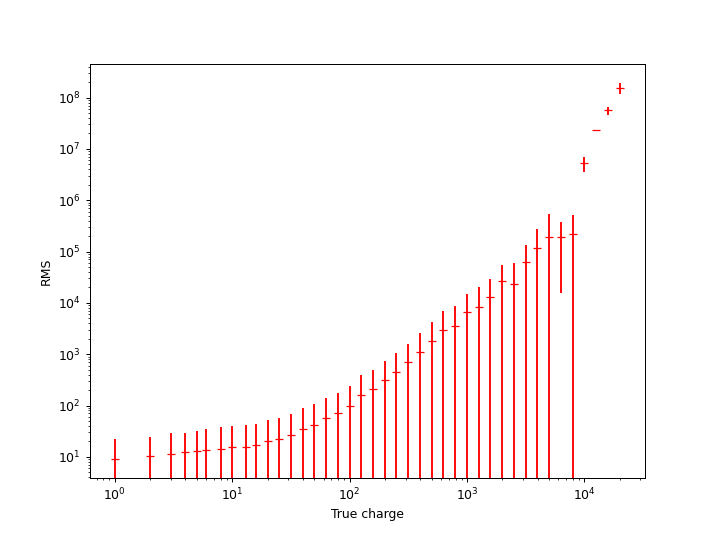

In [23]:
# RMS

p_x, p_mean, p_rms = compute_profile(true_pe, (recon_pe-true_pe)**2, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.ylabel("RMS")
plt.xlabel("True charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.show()